### **군집화 기반 앙상블 페어선택 알고리즘**
기여자 : 12기 최문석, 13기 최원준  

페어트레이딩을 위한 페어선택 알고리즘을 테스트합니다.

## 1. 동기

## 2. 관련 연구

## 3. 데이터셋
- 데이터셋은 FnGuide에서 제공하는 데이터를 사용하였습니다.


In [267]:
import os
import glob
import math
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

In [268]:
# matplotlib library load
import matplotlib.pyplot as plt

# plot 한글 보이게
from matplotlib import rc
rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

In [269]:
csv_data = pd.read_csv(r"../data/Train_Data.csv", encoding='CP949')
val_data = pd.read_csv(r"../data/Validation Data.csv", encoding='CP949')
test_data = pd.read_csv(r"../data/Test_Data.csv", encoding='CP949')

C:\Users\user\AppData\Local\Temp\ipykernel_15508\3724181354.py:1: DtypeWarning: Columns (3,4,9,12,18,20,26,27,28,30,32,36,37,44,48,50,54,56,61,63,65,66,68,71,72,73,75,77,80,82,89,91,92,94,96,108,109,112,113,115,116,119,124,130,131,132,133,136,142,143,146,152,153,154,155,158,161,162,163,166,168,169,173,174,175,180,183,185,186,187,192,194,198,199,202,203,204,207,209,210,212,215,216,217,218,220,222,230,231,232,236,245,248,250,251,252,258,259,260,261,262,263,267,269,271,276,279,282,285,286,287,288,290,293,294,295,297,299,300,302,303,312,314,317,318,319,322,323,325,327,328,340,351,353,357,365,374,379,391,393,395,397,399,400,402,405,406,408,410,413,415,416,419,422,423,427,438,439,445,446,448,450,451,454,464,465,467,468,473,475,477,486,493,495,496,498,499,504,506,508,510,511,517,519,521,526,543,546,558,560,561,562,565,571,572,574,576,579,580,586,591,596,599,600,601,605,616,622,623,625,627,635,639,641,643,648,652,659,663,667,671,678,679,680,684,687,689,690,695,698,700,703,704,711,716,719,721,7

In [270]:
csv_data.columns = csv_data.iloc[0]
csv_data = csv_data.iloc[1:]
csv_data.set_index('Symbol Name', inplace=True)
csv_data = csv_data.replace(',', '', regex=True).astype(float)

val_data.columns = val_data.iloc[0]
val_data = val_data.iloc[1:]
val_data.set_index('Symbol Name', inplace=True)
val_data = val_data.replace(',', '', regex=True).astype(float)

test_data.columns = test_data.iloc[0]
test_data = test_data.iloc[1:]
test_data.set_index('Symbol Name', inplace=True)
test_data = test_data.replace(',', '', regex=True).astype(float)

In [271]:
print('행 :', len(csv_data), '열 :', len(csv_data.T))
print('행 :', len(val_data), '열 :', len(val_data.T))
print('행 :', len(test_data), '열 :', len(test_data.T))

행 : 2979 열 : 1210
행 : 732 열 : 1210
행 : 1235 열 : 1210


In [272]:
total_data = pd.concat([csv_data, val_data, test_data])
total_data = total_data.dropna(axis=1)

In [273]:
len(total_data)

4946

In [274]:
csv_data = total_data.iloc[:2979]
val_data = total_data.iloc[2979:2979+732]
test_data = total_data.iloc[2979+732:]
simul_data = val_data = total_data.iloc[:2979+732]

In [275]:
print('행 :', len(csv_data), '열 :', len(csv_data.T))
print('행 :', len(val_data), '열 :', len(val_data.T))
print('행 :', len(test_data), '열 :', len(test_data.T))

행 : 2979 열 : 523
행 : 3711 열 : 523
행 : 1235 열 : 523


In [276]:
data = csv_data
data = np.log(data / data.shift(1))
data = data.dropna(axis=0)
log_return_data = data
scaler = StandardScaler()
datanp = scaler.fit_transform(data.T)
data = pd.DataFrame(datanp, columns=data.index, index=data.columns)

In [277]:
data

Symbol Name,2004-04-02,2004-04-06,2004-04-07,2004-04-08,2004-04-09,2004-04-12,2004-04-13,2004-04-14,2004-04-16,2004-04-19,...,2016-03-18,2016-03-21,2016-03-22,2016-03-23,2016-03-24,2016-03-25,2016-03-28,2016-03-29,2016-03-30,2016-03-31
0,,,,,,,,,,,,,,,,,,,,,
삼성전자,-0.844920,1.581603,0.050955,0.092268,-0.387346,0.488913,0.390982,-0.035050,-1.048525,0.198708,...,0.195054,-0.150383,-0.007296,0.476627,0.172015,0.183459,0.291434,-0.474514,0.427939,0.160107
SK하이닉스,0.166528,3.042484,-0.213993,-0.793731,0.455002,-0.300025,0.775768,-1.653495,-1.936104,0.452401,...,0.154402,0.168102,0.757765,0.204601,-0.899479,-0.446189,-0.670959,0.214722,-0.629596,-0.893619
현대차,-0.226459,0.654561,0.722449,0.177745,-0.633777,-0.358543,-0.518778,-0.044157,0.192855,-0.848962,...,0.917407,1.064619,1.021313,-0.145074,-0.500479,-0.698281,0.362052,-0.042925,-0.070987,-0.989254
기아,-0.654652,0.452490,0.700000,-0.048772,-1.251201,-0.568563,-0.609895,0.774088,-0.066026,0.767445,...,-0.064124,1.092629,1.378004,-0.741031,-0.099141,-0.227378,-0.192466,0.668523,-0.930998,-0.989085
POSCO홀딩스,0.944643,-0.327819,0.450583,1.169662,0.494605,-0.660112,-0.849169,0.633708,-0.873958,-0.182886,...,0.604766,-0.606155,-0.067091,0.543301,-0.869083,0.087173,0.295759,0.619213,0.749591,0.004369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
한솔PNS,0.479527,0.511836,0.728193,-0.917641,-0.869550,3.188219,-2.225668,0.021783,0.777729,0.657577,...,-0.523216,0.595775,0.635193,0.131962,-0.053994,1.746840,1.273206,-0.790346,1.021509,-1.013956
한창,-2.121926,4.820095,3.839426,-4.334213,-2.096974,0.021568,-0.569084,-0.340529,1.802854,4.528300,...,-0.187871,-0.435081,-0.067091,-0.207734,-2.004809,1.729928,0.242915,-0.283321,-0.222058,-0.167050
SHD,0.977920,-0.921425,-0.541036,0.627228,-0.440279,-0.300025,-0.253803,0.735784,0.399079,-0.120543,...,1.187133,0.137220,-0.458942,-0.443350,0.278882,0.426229,-0.376377,-0.572273,0.999593,-0.522828


In [278]:
from scipy.linalg import svd
U, s, VT = svd(data)

In [279]:
V = VT.T
PC_V = V[:,0:15]
print(PC_V.shape)

(2978, 15)


In [280]:
eigendata = data@PC_V
eigendata

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,
삼성전자,1.770964,-6.729498,3.749208,-3.054355,1.968846,-4.169626,0.186324,-4.615513,-1.122382,1.873062,-3.107006,0.400318,-1.884646,2.288566,-0.906097
SK하이닉스,8.500098,0.349412,3.108367,-5.219802,3.711411,-5.208028,0.719121,-4.089500,-0.246777,4.216246,-4.453237,0.574761,-3.047649,4.860980,-0.937767
현대차,4.819456,-8.995193,6.959481,-2.117423,3.710173,-9.120123,1.246686,-0.481555,-1.671482,5.048648,-6.708878,4.566158,-3.566264,-0.399058,-2.509971
기아,5.134973,-7.619334,5.499325,-2.748352,3.725945,-9.844074,1.262114,-1.535799,-0.938749,5.883200,-6.493398,3.750740,-3.237430,-0.298247,-2.401688
POSCO홀딩스,5.755528,-10.072063,2.490473,1.325004,-1.156618,-1.228158,-2.332886,1.524601,0.733567,-1.211564,-0.890578,-2.117609,1.752423,-1.173360,-0.602845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
한솔PNS,0.148646,7.233599,-1.224608,-1.157813,1.704054,-2.358929,4.461557,-2.881558,1.379103,0.576167,0.585491,2.998036,-1.236748,8.836316,4.457297
한창,-5.111762,8.623162,2.442489,-2.634537,-3.391267,1.173109,-4.451027,-8.755044,4.015884,-7.314709,-12.738724,-9.768938,-4.104851,8.768661,8.694788
SHD,-5.726618,1.824647,1.734338,2.233627,-1.544036,-0.755911,0.060593,0.430215,2.115697,0.166172,0.829901,-1.958977,-1.943193,1.964511,-3.236497


In [281]:
pc_names = ['PC' + str(i) for i in range(1, len(eigendata.columns) + 1)]
eigendata.columns = pc_names

In [282]:
pca_df = eigendata

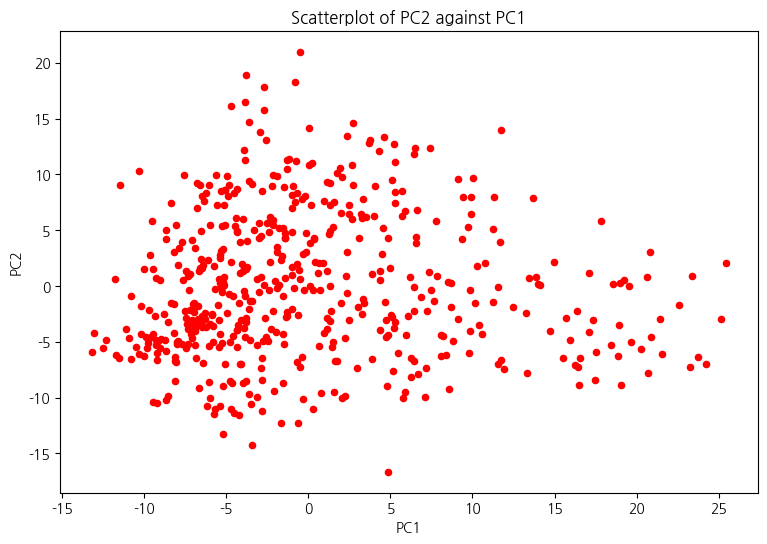

In [283]:
'''
Visualising the PCA in dimension R^2 (PC1 and PC2)
'''

fig, ax = plt.subplots(figsize=(9,6))
pca_df.plot(x="PC1", y="PC2", kind="scatter", marker="o",
    title="Scatterplot of PC2 against PC1", ax=ax, color="r")
plt.show()

---

**20개 주성분 선택**  
카이저-가트맨 규칙(Kaiser-Guttman Criterion)의 고윳값1기준

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\

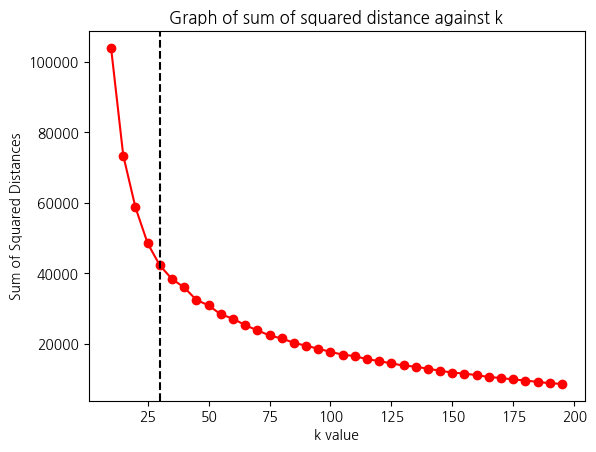

From the graph above, we can see that the optimal k-value is at the elbow, at k = 30


In [284]:
'''Make a pointer to store clustering results'''

cluster_results = {}

'''K-Means Clustering'''

def optimise_k(pca_df):

    error = []
    ks = []
    
    for i in range(10, 200, 5): # For loop from 10 to 200 with intervals of 5 and calculate the respective sum of squared distances for i number of centroids

        # Initialise the KMeans function with the i number of centroids.
        # By default, KMeans function uses the KMeans++ Method of initialisation the centroids.
        kmeans = KMeans(n_clusters=i) 
        
        # Fits the model with pcd_df and applies KMeans algorithm on pca_df.
        kmeans.fit(pca_df)
        
        # Using the attribute ".inertia_" returns the sum of squared distances of datapoints to their closest cluster center.
        # It is appended into error to be plotted as the y-axis.
        error.append(kmeans.inertia_)
        
        # The number of centroids, i, is appended to ks to be plotted as the x-axis.
        ks.append(i)
    
    # Plot graph of "Sum of Squared Distances" against "k value".
    # Using this graph, the optimal number of centroids can be found via the elbow method
    plt.plot(ks, error, marker="o", color="r")
    plt.title("Graph of sum of squared distance against k")
    plt.xlabel("k value")
    plt.ylabel("Sum of Squared Distances")
    plt.axvline(30, color='black', linestyle='--')
    plt.show()

def cluster_kmeans(pca_df, k):

    # Initialise the KMeans function with the k number of centroids.
    kmeans = KMeans(n_clusters=k)

    # Fits the model with pcd_df and applies KMeans algorithm on pca_df.
    kmeans.fit(pca_df)

    # Using the method .predict(X), it calculates the closest cluster each datapoint in dataset X belongs to.
    results = kmeans.predict(pca_df)

    # Plot the cluster results.
    fig, ax = plt.subplots(figsize=(9,6))
    pca_df.plot(x="PC1", y="PC2", kind="scatter", 
        title=f"K-Means Cluster Results, k={k}", c=results, cmap="jet", ax=ax)
    plt.show()
    return results

optimise_k(pca_df)
print(f"From the graph above, we can see that the optimal k-value is at the elbow, at k = 30")

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


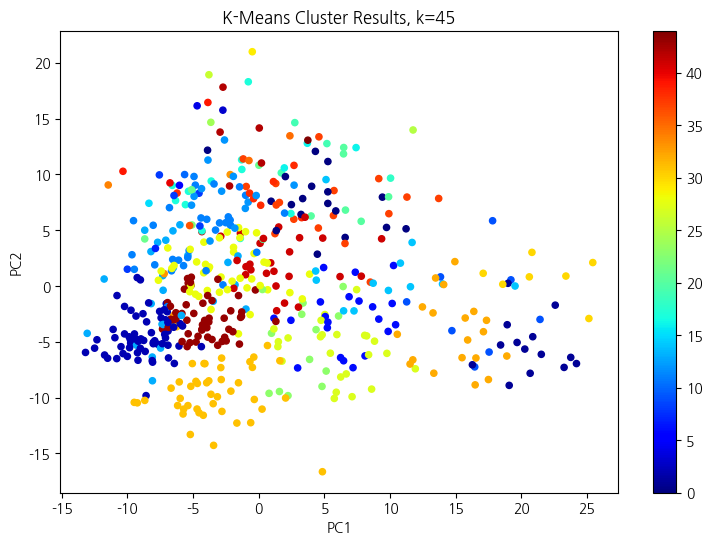

Therefore, we plot the K-Means results for the optimal k-value, 45


In [285]:
'''Plotting the K-Means Cluster Results'''

# K-Means Clustering is applied on pca_df for k = 45
kmeans_results = cluster_kmeans(pca_df,k=45)

# K-Means Clustering results are saved in cluster_results
cluster_results[f"KMeans"] = kmeans_results

print(f"Therefore, we plot the K-Means results for the optimal k-value, 45")

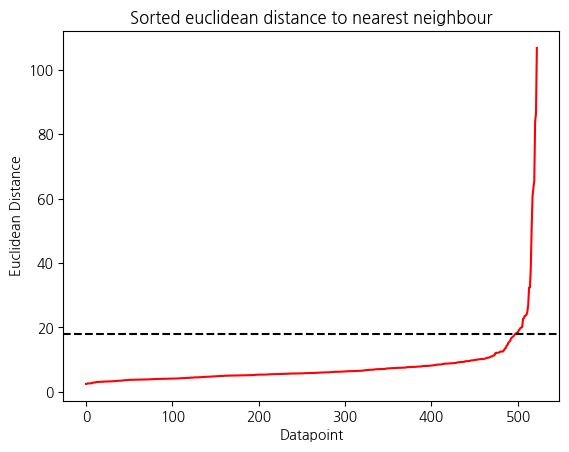

From the graph above, we can see that the optimal epsilon is at the elbow, at epsilon = 18


In [286]:
'''
DBSCAN Clustering:
'''

def optimise_epsilon(pca_df):

    # Initialise the NearestNeighbors function with 2 neighbors 
    # This is to find optimal value of epsilon based on an optimisation algorithm
    neigh = NearestNeighbors(n_neighbors=2)

    # Fits the model with pcd_df
    nbrs = neigh.fit(pca_df)

    # Using the method .kneighbors(X), the k-Neighbours for datatpoints in datatset X are found
    # By default, this method returns the distances array which is found in the 0 index
    distances = nbrs.kneighbors(pca_df)[0]

    # Sort distances row-wise
    distances = np.sort(distances,axis=0) 

    # Remove the 0-index value (Euclidean distance to itself which is 0)
    distances = distances[:,1:]

    # Plot graph of "Euclidean Distance" against "Datapoint".
    # Using this graph, the optimal epsilon value can be found via the elbow method
    plt.plot(distances, color="r")
    plt.title("Sorted euclidean distance to nearest neighbour")
    plt.xlabel("Datapoint")
    plt.ylabel("Euclidean Distance")
    plt.axhline(y=18, color='black', linestyle='--')
    plt.show()    

def cluster_dbscan(pca_df, eps, min_samples):

    # Initialise the DBSCAN function with eps and min_samples.
    # eps is a float value and is the maximum distance between two samples for one to be considered as in the neighborhood of the other
    # min_samples is the number of samples (or total weight) in a neighborhood for a point to be considered as a core point. 
    # This includes the point itself.
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Using the method .fit_predict(X), clusters from a data or distance matrix and predict labels are computed
    results = dbscan.fit_predict(pca_df)
    
    # Plot the cluster results.
    fig, ax = plt.subplots(figsize=(9,6))
    pca_df.plot(x="PC1", y="PC2", kind="scatter", 
        title=f"DBSCAN Cluster Results", c=results, cmap="jet", ax=ax)
    plt.show()

    # Get number of clusters formed.
    num_clusters = np.max(results)
    print(f"For the epsilon value of {eps}, the number of clusters is {num_clusters}")

    return results

optimise_epsilon(pca_df) 
print(f"From the graph above, we can see that the optimal epsilon is at the elbow, at epsilon = 18")

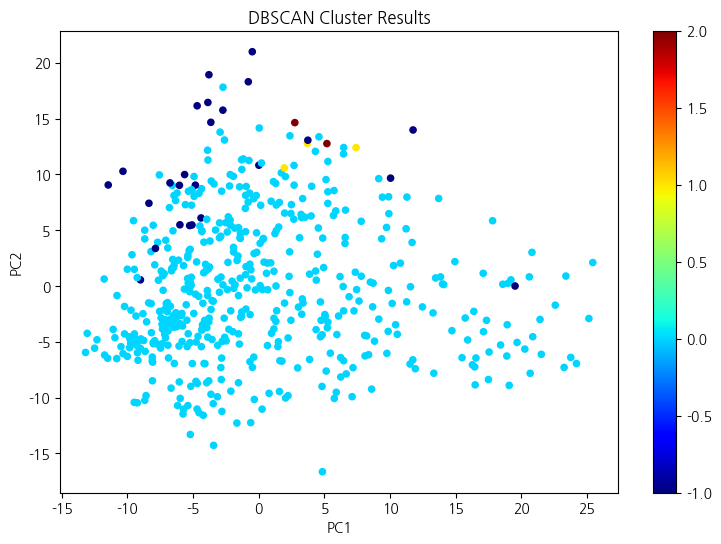

For the epsilon value of 18, the number of clusters is 2


In [287]:
'''Plotting the DBSCAN Cluster Results'''

# DBSCAN Clustering is applied on pca_df for eps = 20 and min_samples = 2
results = cluster_dbscan(pca_df, eps=18, min_samples=2)

# DBSCANS Clustering results are saved in cluster_results, a dict
cluster_results["DBSCAN"] = results

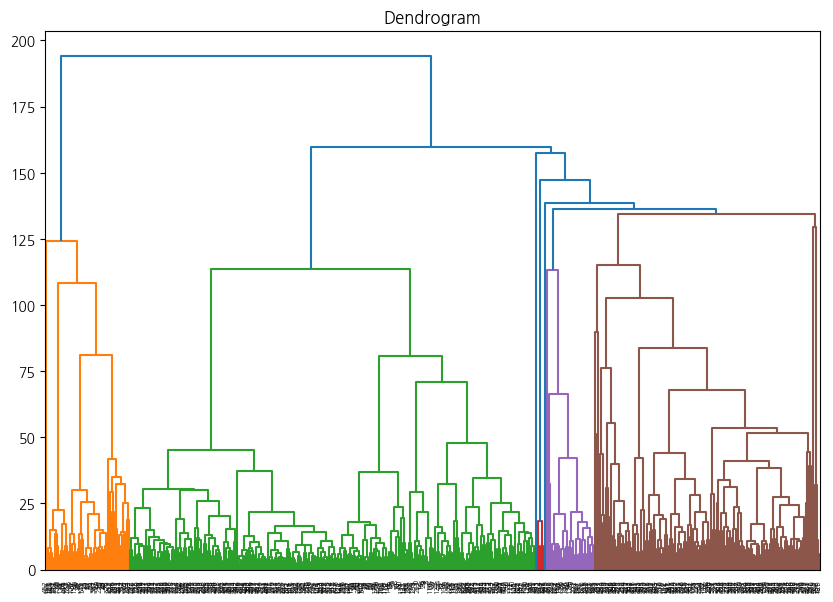

In [288]:
'''
Hierarchical Clustering (AgglomerativeClustering)
'''

def cluster_hierar(pca_df, n):

    # Initialise the AgglomerativeClustering function with n clusters.
    # Fits the model with pca_df and applies Agglomerative Clustering algorithm on pca_df.
    hierar = AgglomerativeClustering(n_clusters=n, ).fit(pca_df)

    # Using the method .fit_predict(X), it fits and return the result of each datapoint's clustering assignment.
    results = hierar.fit_predict(pca_df)

    # Plot cluster results.
    fig, ax = plt.subplots(figsize=(9,6))
    pca_df.plot(x="PC1", y="PC2", kind="scatter", 
        title=f"Agglomerative Clustering Results, n={n}", c=results, cmap="jet", ax=ax)
    plt.show()

    return results

def draw_dendrogram(pca_df):
    
    # Initialise Linkage function with linkage method = "ward".
    # linkage returns a linkage matrix, which is needed for the dendrogram to be plotted.
    linked = linkage(pca_df,method = "ward") 

    # Plot dendrogram results.
    plt.figure(figsize =(10,7))
    plt.title("Dendrogram")
    dendrogram(linked,
                orientation = "top",
                distance_sort = "descreasing",
                show_leaf_counts = True)
    plt.show()

draw_dendrogram(pca_df)

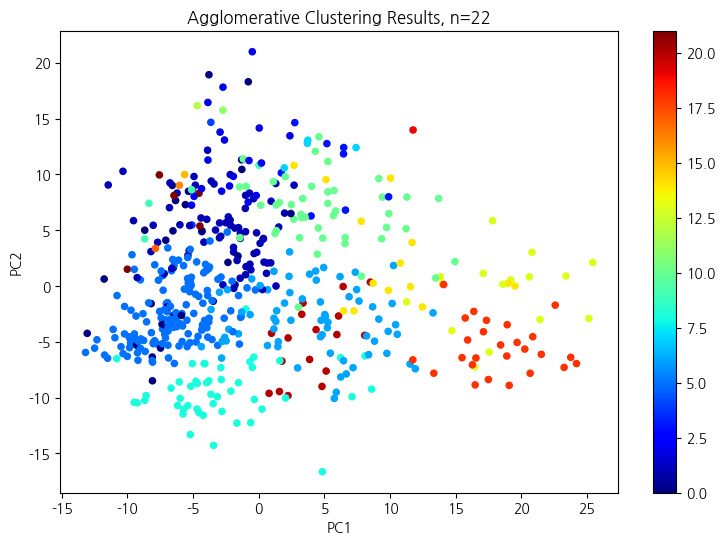

In the case of Hierarchical Clustering, we chose the optimal number of clusters to be sqrt(N)=22, where N is the number of datapoints


In [289]:
'''Plotting the Hierarchical Cluster Results'''
# Hierarchical Clustering is applied on pca_df for n_clusters = sqrt(N)
results = cluster_hierar(pca_df, int(pca_df.shape[0]**0.5)) 

# Hierarchical Clustering results are saved in cluster_results
cluster_results["Hierarchical"] = results

print(f"In the case of Hierarchical Clustering, we chose the optimal number of clusters to be sqrt(N)=22, where N is the number of datapoints")

In [290]:
'''
Cluster Results -> Groupings of stocks/ETFs:
1. First, we need to map the cluster ids to the symbols of our stocks to get groups of stocks
2. Then store the clusters into a pointer -> "groups"
'''
norm_symbols = pca_df.index

# Return array of the symbols of stocks.
print(norm_symbols.shape) 

# Contains cluster group assignments for each algorithm.
print([x.shape for x in cluster_results.values()])

def map_clusters(cluster_result):
    grouping = [[] for _ in range(max(cluster_result)+1)]
    for i, res in enumerate(cluster_result):
        grouping[res].append(norm_symbols[i])
    
    grouping = [g for g in grouping if 1<len(g)<=10] # Keep clusters with <=10 members.
    
    return grouping

groups = {}
for algorithm, cluster_result in cluster_results.items():
    groups[algorithm] = map_clusters(cluster_result)


print("Number of valid clusters:", {k:len(v) for k,v in groups.items()})
print("Example cluster:", groups["Hierarchical"][0])

(523,)
[(523,), (523,), (523,)]
Number of valid clusters: {'KMeans': 12, 'DBSCAN': 1, 'Hierarchical': 5}
Example cluster: ['NI스틸', '광명전기', '동양철관', '일신석재', '대호에이엘', '하이스틸', 'DSR제강', '문배철강', '선도전기']


In [291]:
for i in range(0,len(groups["KMeans"])):
    print("Example cluster:", groups["KMeans"][i])

Example cluster: ['사조대림', '사조산업', '사조오양', '한성기업', '동원수산']
Example cluster: ['NH투자증권', '한국금융지주', '삼성증권', '대신증권', '유진투자증권', '현대차증권', '다올투자증권', '한양증권']
Example cluster: ['삼화콘덴서', '삼화전기', '삼화전자']
Example cluster: ['광명전기', '일신석재', '선도전기']
Example cluster: ['NI스틸', '동양철관', '대호에이엘', '대양금속', '하이스틸', 'DSR제강', '문배철강']
Example cluster: ['미래산업', '우성', '한창']
Example cluster: ['미래에셋증권', '한화투자증권', '교보증권', '유안타증권', 'SK증권', 'DB금융투자', '상상인증권']
Example cluster: ['동원산업', '신라교역', 'CJ씨푸드']
Example cluster: ['대유에이텍', '대유플러스']
Example cluster: ['동원시스템즈', '디아이', '덕성', '삼익악기', '이스타코', '한솔PNS', '비케이탑스']
Example cluster: ['플레이그램', '에이엔피']
Example cluster: ['모나리자', '신일전자', '모나미', '세우글로벌', '윌비스']


In [292]:
for i in range(0,len(groups["Hierarchical"])):
    print("Example cluster:", groups["Hierarchical"][i])

Example cluster: ['NI스틸', '광명전기', '동양철관', '일신석재', '대호에이엘', '하이스틸', 'DSR제강', '문배철강', '선도전기']
Example cluster: ['이엔플러스', '대우부품']
Example cluster: ['삼화콘덴서', '삼화전기', '삼화전자', '성문전자']
Example cluster: ['써니전자', '미래산업', '우성', '한창']
Example cluster: ['사조대림', '사조산업', '사조오양', '한성기업', '동원수산']


In [293]:
for i in range(0,len(groups["DBSCAN"])):
    print("Example cluster:", groups["DBSCAN"][i])

Example cluster: ['삼화콘덴서', '삼화전기', '삼화전자']


In [294]:
cumulative_log_returns = log_return_data.cumsum()
cumulative_returns = np.exp(cumulative_log_returns) - 1

In [295]:
def clusterCumsumPlot(name_clustering_algorithm):
    for i in range(0, len(groups[name_clustering_algorithm])):
        plt.figure(figsize=(10, 6))
        cluster = groups[name_clustering_algorithm][i]
        for stock in cluster:
            if stock in cumulative_returns.columns:
                cumulative_returns[stock].plot(label=stock)
        plt.title(f'{name_clustering_algorithm} 군집화 알고리즘 - {i+1}번째 군집')
        plt.xlabel('날짜')
        plt.ylabel('누적수익률')
        plt.legend()
        plt.grid(True)
        plt.show()

In [296]:
#clusterCumsumPlot("DBSCAN")

In [297]:
#clusterCumsumPlot("KMeans")

In [298]:
#clusterCumsumPlot("Hierarchical")

## 4. Validation

In [299]:
val_log_returns = np.log(val_data / val_data.shift(1))
val_log_returns = val_log_returns.dropna(axis=0)

In [300]:
val_log_returns 

,삼성전자,SK하이닉스,현대차,기아,POSCO홀딩스,NAVER,삼성SDI,LG화학,신한지주,현대모비스,...,신풍,동원수산,제이준코스메틱,금호전기,한국주강,한솔PNS,한창,SHD,비케이탑스,일정실업
Symbol Name,,,,,,,,,,,,,,,,,,,,,
2004-04-02,-0.017544,0.008000,-0.001925,-0.012739,0.027652,0.036917,0.000000,-0.005434,0.049376,0.010949,...,-0.004283,-0.031416,-0.010309,0.016872,-0.046437,0.015905,-0.049795,0.028492,0.015248,0.000000
2004-04-06,0.051736,0.091318,0.026618,0.021142,0.000000,0.024600,0.023461,0.017996,0.042665,-0.001817,...,-0.012959,-0.059163,0.015424,0.034803,0.035911,0.022750,0.139482,-0.016084,0.007518,0.007001
2004-04-07,0.008368,0.000000,0.029577,0.028868,0.020990,0.017527,-0.011662,-0.008951,0.000000,-0.018349,...,0.000000,0.138878,-0.005115,0.033653,0.069816,0.029758,0.128025,-0.010329,0.007462,0.003482
2004-04-08,0.008299,-0.018349,0.010870,0.004057,0.040703,-0.012062,0.008759,-0.014496,0.000000,0.005540,...,-0.010929,0.125394,0.017790,0.043178,0.057524,-0.022076,-0.124835,0.024389,0.034143,0.006928
2004-04-09,-0.016667,0.007380,-0.023702,-0.041328,0.008511,0.017433,-0.032499,-0.012862,-0.011052,-0.031808,...,-0.004405,-0.123432,-0.005051,0.051476,0.024541,-0.030433,-0.065473,-0.018178,-0.021791,0.020559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-25,-0.022815,-0.042960,-0.028749,-0.020499,-0.023439,-0.007905,-0.025975,-0.033493,-0.006961,-0.030772,...,-0.011215,-0.033394,-0.014390,-0.005676,-0.047165,0.014235,0.086120,-0.008969,-0.004596,0.002599
2019-03-26,-0.005510,-0.002747,-0.012579,0.008837,0.005911,0.003960,0.002389,-0.001363,-0.004667,0.011948,...,0.003752,0.000000,-0.004838,-0.032790,0.022473,0.000000,0.020849,0.002225,0.006898,0.002548
2019-03-27,0.002208,0.009583,0.000000,0.014556,0.001963,-0.028058,0.002384,-0.010974,0.000000,-0.011948,...,0.003738,-0.004695,-0.014671,0.009756,-0.005571,0.007042,-0.012826,0.013394,-0.042073,0.012644


In [301]:
val_log_returns[groups["KMeans"][0]]

,사조대림,사조산업,사조오양,한성기업,동원수산
Symbol Name,,,,,
2004-04-02,-0.082103,-0.028379,-0.025525,-0.035846,-0.031416
2004-04-06,-0.005354,-0.016404,-0.063953,-0.048608,-0.059163
2004-04-07,0.135531,0.138766,0.139709,0.139262,0.138878
2004-04-08,0.135875,0.111983,0.138437,0.107359,0.125394
2004-04-09,0.012219,-0.126484,-0.128836,-0.136101,-0.123432
...,...,...,...,...,...
2019-03-25,-0.021609,-0.018868,-0.017798,-0.017422,-0.033394
2019-03-26,0.012063,0.024460,-0.002247,-0.012379,0.000000
2019-03-27,0.026037,0.012927,0.001124,0.000000,-0.004695


In [302]:
def get_r_squared(group):
    df = val_log_returns[group]
    corr = df.corr() # Correlation matrix
    corr.values[np.tril_indices_from(corr)] = np.nan # Keep only upper triangular of the correlation matrix
    return corr.unstack().mean() # Return mean of the correlation matrix


def average_correlation(groups):
    avg_corr = {}
    for algorithm, cluster_result in groups.items():
        corrs = []
        for group in cluster_result:
            corr = get_r_squared(group)
            corrs.append(corr)
        avg_corr[algorithm] = np.mean(np.square(corrs)) # Take mean of r-squared 
    return avg_corr

corr_metrics = average_correlation(groups)
pd.DataFrame(corr_metrics.items(), columns=["Algorithm", "R-Squared"])

,Algorithm,R-Squared
0,KMeans,0.164073
1,DBSCAN,0.332542
2,Hierarchical,0.127927


In [303]:
from sklearn.metrics import silhouette_score

def prepare_labels(data, groups):
    # Prepare a mapping from stock names to their positions to align labels
    stock_indices = {stock: index for index, stock in enumerate(data.columns)}
    
    # Prepare labels for each algorithm
    prepared_labels = {}
    for algorithm, clusters in groups.items():
        labels = [-1] * len(data.columns)  # Initialize with -1 for any potentially unassigned stocks
        for cluster_index, stocks in enumerate(clusters):
            for stock in stocks:
                if stock in stock_indices:
                    labels[stock_indices[stock]] = cluster_index
        prepared_labels[algorithm] = labels
    return prepared_labels

def calculate_silhouette_scores(data, groups):
    prepared_labels = prepare_labels(data, groups)
    silhouette_scores = {}
    for algorithm, labels in prepared_labels.items():
        # Check if labels have been properly assigned (avoid all -1 scenario)
        if len(set(labels)) > 1:
            score = silhouette_score(data.T, labels)  # Transpose to align samples with features
            silhouette_scores[algorithm] = score
        else:
            silhouette_scores[algorithm] = None  # No valid scoring if all labels are -1
    return silhouette_scores

# Assuming `groups` contains your cluster data as previously formatted
silhouette_scores = calculate_silhouette_scores(val_log_returns, groups)

# Display the results in a DataFrame
import pandas as pd
results_df = pd.DataFrame(silhouette_scores.items(), columns=["Algorithm", "Silhouette Score"])
print(results_df)


      Algorithm  Silhouette Score
0        KMeans         -0.081145
1        DBSCAN          0.169705
2  Hierarchical          0.112489


In [305]:
import json
with open('cluster_data3.json', 'w', encoding='utf-8') as f:
    json.dump(groups, f, ensure_ascii=False, indent=4)